In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Load and preprocess data
loan_df = pd.read_csv('loan_data.csv')
columns_to_encode = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
label_encoder = LabelEncoder()
loan_df_encoded = loan_df[columns_to_encode].apply(lambda col: label_encoder.fit_transform(col))
loan_df_encoded = pd.concat([loan_df.drop(columns_to_encode, axis=1), loan_df_encoded], axis=1)

print(loan_df_encoded.head())

def get_train_valid_test_data(X: np.ndarray, y: np.ndarray):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=0.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=0.8, random_state=42)
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

# Activation functions
class Sigmoid:
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        sig = Sigmoid.activation(z)
        return sig * (1 - sig)

class Tanh:
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        return np.tanh(z)

    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        return 1 - np.tanh(z)**2

def init_weights(input_size, hidden_neurons, output_neurons):
    W1 = np.random.randn(input_size, hidden_neurons) * 0.01
    b1 = np.zeros((1, hidden_neurons))
    W2 = np.random.randn(hidden_neurons, output_neurons) * 0.01
    b2 = np.zeros((1, output_neurons))
    return W1, b1, W2, b2

def get_batches(data_size, batch_size):
    indices = np.arange(data_size)
    np.random.shuffle(indices)
    for start in range(0, data_size, batch_size):
        yield indices[start:start + batch_size]

def hidden_layer_grads(X, y, W1, Z1, A1, W2, Z2, A2):
    delta2 = A2 - y.reshape(-1, 1)
    delta1 = (delta2 @ W2.T) * Tanh.derivative(Z1)

    W1_avg_grad = X.T @ delta1 / len(y)
    b1_avg_grad = np.sum(delta1, axis=0, keepdims=True) / len(y)

    return W1_avg_grad, b1_avg_grad


def output_layer_grads(X, y, W1, Z1, A1, W2, Z2, A2):
    delta = A2 - y.reshape(-1, 1)

    W2_avg_grad = A1.T @ delta / len(y)
    b2_avg_grad = np.sum(delta, axis=0, keepdims=True) / len(y)

    return W2_avg_grad, b2_avg_grad

def forward(X: np.ndarray, W1, b1, W2, b2):
    Z1 = (X @ W1) + b1
    A1 = Tanh.activation(Z1)
    Z2 = (A1 @ W2) + b2
    A2 = Sigmoid.activation(Z2)
    return Z1, A1, Z2, A2

class NeuralNetwork:
    def __init__(self, hidden_neurons, output_neurons, alpha, batch_size, epochs, seed=0):
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.alpha = alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None

    def fit(self, X, y, X_vld=None, y_vld=None):
        np.random.seed(self.seed)
        self.W1, self.b1, self.W2, self.b2 = init_weights(X.shape[1], self.hidden_neurons, self.output_neurons)
        for epoch in range(self.epochs):
            for batch in get_batches(len(X), self.batch_size):
                X_b = X[batch]
                y_b = y[batch]
                Z1, A1, Z2, A2 = forward(X_b, self.W1, self.b1, self.W2, self.b2)
                W2_grad, b2_grad = output_layer_grads(X_b, y_b, self.W1, Z1, A1, self.W2, Z2, A2)
                W1_grad, b1_grad = hidden_layer_grads(X_b, y_b, self.W1, Z1, A1, self.W2, Z2, A2)
                self.W1 -= self.alpha * W1_grad
                self.b1 -= self.alpha * b1_grad
                self.W2 -= self.alpha * W2_grad
                self.b2 -= self.alpha * b2_grad
            if X_vld is not None and y_vld is not None:
                y_pred = (self.predict(X_vld) >= 0.5).astype(int)
                acc = accuracy_score(y_vld, y_pred)
                print(f"Epoch {epoch + 1}/{self.epochs}, Validation Accuracy: {acc:.4f}")

    def predict(self, X):
        _, _, _, A2 = forward(X, self.W1, self.b1, self.W2, self.b2)
        return A2

# Metrics
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

# Training the Model
hidden_neurons = 128
output_neurons = 1
alpha = 0.01
batch_size = 32
epochs = 100

X = loan_df_encoded.drop(columns=["loan_status"]).values
y = (loan_df_encoded["loan_status"].values > 0).astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.8, random_state=42)
X_vld, X_test, y_vld, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train = scaler.transform(X_train)
X_vld = scaler.transform(X_vld)
X_test = scaler.transform(X_test)


nn_model = NeuralNetwork(hidden_neurons, output_neurons, alpha, batch_size, epochs)
nn_model.fit(X_train, y_train, X_vld=X_vld, y_vld=y_vld)

y_test_pred = (nn_model.predict(X_test) >= 0.5).astype(int)
evaluate_model(y_test, y_test_pred)


   person_age  person_income  person_emp_exp  loan_amnt  loan_int_rate  \
0        22.0        71948.0               0    35000.0          16.02   
1        21.0        12282.0               0     1000.0          11.14   
2        25.0        12438.0               3     5500.0          12.87   
3        23.0        79753.0               0    35000.0          15.23   
4        24.0        66135.0               1    35000.0          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  loan_status  \
0                 0.49                         3.0           561            1   
1                 0.08                         2.0           504            0   
2                 0.44                         3.0           635            1   
3                 0.44                         2.0           675            1   
4                 0.53                         4.0           586            1   

   person_gender  person_education  person_home_ownership  loan_inte

In [27]:
from sklearn.neighbors import KNeighborsClassifier

loan_df = pd.read_csv('loan_data.csv')
label_encoders = {}

df_columns = loan_df.select_dtypes(include=['object']).columns
for column in df_columns:
    le = LabelEncoder()
    loan_df[column] = le.fit_transform(loan_df[column])
    label_encoders[column] = le

if loan_df['loan_status'].isnull().any():
    print("Missing values found in 'loan_status'. Handling them by dropping rows.")
    loan_df = loan_df.dropna(subset=['loan_status'])

X = loan_df.drop(columns=['loan_status']).values
y = loan_df['loan_status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Accuracy: 0.8918888888888888
Precision: 0.7856749311294766
Recall: 0.709452736318408
F1 Score: 0.7456209150326797
Confusion Matrix:
[[6601  389]
 [ 584 1426]]


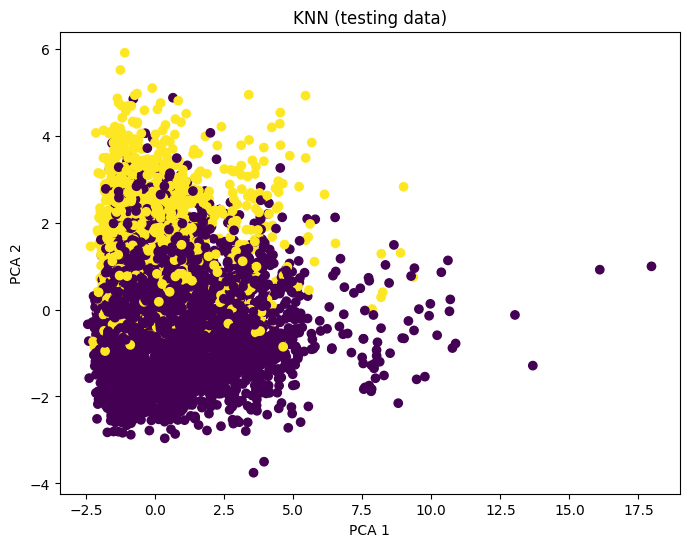

In [28]:
# Plot the boundary using PCA
from sklearn.decomposition import PCA

plt.figure(figsize=(8, 6))

plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='viridis', marker='o', label='Test Data')

plt.title('KNN (testing data)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()